In [15]:
import random as rd
import numpy as np
import pandas as pd
import datetime as dt

from collections import defaultdict
from copy import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Subscripts and superscripts in labels
def subs(j):
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return str(j).translate(SUB)

def sups(j):
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    return str(j).translate(SUP)

_PALETTES = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
             'Dark2', 'Set1', 'Set2', 'Set3',
             'tab10', 'tab20', 'tab20b', 'tab20c']

_LINESTYLES = ['solid',(0, (1, 10)), (0, (1, 5)), (0, (1, 1)),
               (0, (5, 10)), (0, (5, 5)), (0, (5, 1)),
               (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)),
               (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))]

_PROBS = [[0.0,0.0],[0.1,0.3],[0.3,0.1],[0.3,0.6]]
#_PROBS = [[0.0,0.0],[0.1,0.3],[0.3,0.1],[0.1,0.6],[0.6,0.1],[0.3,0.6],[0.6,0.3]]

In [16]:
def outer_cost(system_matrix):
    def inner_cost(j):
        try:
            return system_matrix.iloc[0,j]
        except IndexError:
            print('No server #%i' % j)
            return None
    return inner_cost

def outer_servicerate(system_matrix):
    def inner_servicerate(j):
        try:
            return system_matrix.iloc[1,j]
        except IndexError:
            print('No server #%i' % j)
            return None
    return inner_servicerate

def outer_arrivalrate(system_matrix):
    def inner_arrivalrate(j):
        try:
            return system_matrix.iloc[2,j]
        except IndexError:
            print('No server #%i' % j)
            return None
    return inner_arrivalrate

def outer_delta(system_matrix):
    def inner_delta(j):
        try:
            return system_matrix.iloc[4,j]
        except IndexError:
            print('No server #%i' % j)
            return None
    return inner_delta

In [17]:
def SetParameters(random=True):
    ''' Define the set of parameters. Returns the costs, arrival and service rates as vectors '''

    # Ask for number of dedicated servers
    while True:
        try:
            n_servers = int(input('Nº of Dedicated Servers: '))
            break
        except ValueError:
            pass
    print()
    
    # Set costs and rates randomly
    if random:
        costs         = [0]*(n_servers+1)
        serv_rates    = [0]*(n_servers+1)
        arrival_rates = [0]*(n_servers+1)
    
        rd.seed(n_servers)
        for j in range(n_servers+1):
            costs[j] = round(rd.uniform(1,90))
            if j > 0:
                serv_rates[j]    = np.ceil(rd.uniform(10,40))
                arrival_rates[j] = round(rd.uniform(1,20))
        # The service rate of MSS is set to make the system stable (or stabilizable)
        min_r0 = sum([arrival_rates[s]-serv_rates[s] for s in range(1,n_servers+1) if arrival_rates[s]>serv_rates[s]])
        if min_r0 == 0:
            min_r0 = min([serv_rates[s] for s in range(1,n_servers+1)])
        serv_rates[0] = np.ceil(rd.uniform(min_r0,min_r0*rd.uniform(1.01,4)))
    
    else:
    # Ask the user to enter all the parameters
        while True:
            try:
                str_costs = input('Vector of Costs (size %i, first MSS): ' % (n_servers+1))
                break
            except ValueError:
                pass
        costs = [float(c) for c in str_costs.split()]
        
        while True:
            try:
                str_serv = input('Vector of Service Rates (size %i, first MSS): ' % (n_servers+1))
                break
            except ValueError:
                pass
        serv_rates = [float(r) for r in str_serv.split()]
        
        while True:
            try:
                str_arrival = input('Vector of Arrival Rates (size %i, not for MSS): ' % n_servers)
                break
            except ValueError:
                pass
        arrival_rates = [float(l) for l in str_arrival.split()]
        arrival_rates.insert(0,0)
        
    return costs,serv_rates,arrival_rates

In [18]:
def CreateSystem(costs,service_rates,arrival_rates,load_rates=None):
    ''' Given the set of parameters (as vectors) returns a system as a matrix whose columns are the servers and rows
        are costs, service rates, arrival rates, relative costs and deltas '''
    
    n_servers = len(costs)
    system = pd.DataFrame(data=0,
                          columns = ['$S$'+subs(j) for j in range(n_servers)],
                          index = ['$c$','$r$','$\lambda$','$c/r$','$\delta$'])
    
    system.iloc[0,:]  = costs
    system.iloc[1,:]  = service_rates
    system.iloc[2,:]  = arrival_rates
    system.iloc[3,:]  = [round(system.iloc[0,s]/system.iloc[1,s],2) for s in range(n_servers)]
    system.iloc[4,0]  = 1
    system.iloc[4,1:] = [round(np.sqrt(system.iloc[3,s]/system.iloc[3,0]),2) for s in range(1,n_servers)]
    
    global c,r,l,delta
    c     = outer_cost(system)
    r     = outer_servicerate(system)
    l     = outer_arrivalrate(system)
    delta = outer_delta(system)
        
    return system

In [19]:
def Stability(system,loads=None):
    ''' Returns True if system is stable '''
    
    n_servers = len(system.columns)
    if not loads:
        loads = np.array([l(s)/r(s) for s in range(n_servers)])
    else:
        loads = np.array(loads)
    if any(loads>=1):
        return False
    else:
        return True

#### Remark
To make sure that the partition does not result in any negative load is necessary that:

$\rho_0\geq 0\;\Longrightarrow\;\sum\limits_{l\in\mathcal{S}^+}r_l\left(1-\delta_l\right) \leq \sum\limits_{k\in\mathcal{S}^*}\lambda_k$

$\rho_j\geq 0\;\Longrightarrow\;r_0\left(1-\dfrac{1}{\delta_j}\right)+\sum\limits_{l\in\mathcal{S}^+}r_l\left(1-\dfrac{\delta_l}{\delta_j}\right) \leq \sum\limits_{k\in\mathcal{S}^*}\lambda_k,\quad\forall j\in\mathcal{S}^+$

We allow unstable servers ($\rho_j\geq 1$); further reassignations will turn them into stable servers if the stability condition $r_0+\sum\limits_{j\in A}r_j>\sum\limits_{i\in A}\lambda_i$ is satisfied (it always does when parameters are randomly chosen).

### Functions

(the load of a unstable server is set to 1)

In [20]:
def rho0(system,Splus,S0):
    ''' INPUT
        system: matrix of parameters
        Splus : set of servers that share part of their load
        S0    : set of servers that pass all of their load
        
        OUTPUT
        rho_0: MSS load rate (according to formulae in last chapter) '''
    
    r0    = r(0)
    sum1  = sum([r(s)-l(s) for s in Splus])
    sum2  = sum([l(s) for s in S0])
    sum3  = sum([r(s)*delta(s) for s in Splus])
    rho_0 = 1-(r0+sum1-sum2)/(r0+sum3)
    return min(1.,round(rho_0,3))

In [21]:
def rhoj(j,system,Splus,S0):
    ''' INPUT
        j     : server 
        system: parameters matrix
        Splus : set of servers that share part of their load
        S0    : set of servers that pass all of their load
        
        OUTPUT
        rho_j : server load rate 
        '''
    
    if j in S0:       
        return 0
    elif j in Splus:
        rho_0  = rho0(system,Splus,S0)
        rho_j  = 1-(delta(j)*(1-rho_0))
        return min(1.,round(rho_j,3))
    else:
        return min(1.,round(l(j)/r(j),3))

In [22]:
def SetPartition(system,p0=0.1,p1=0.3):
    ''' Given a system of servers, assigns each dedicated one to S0,S+ or Sd according to 
        the probabilities (p0,p1,1-p0-p1)
    '''
    
    S0 = set(); Splus = set(); Sd = set()
    n_servers = len(system.columns)
    
    for s in range(1,n_servers):
        assign = rd.uniform(0,1)
        if assign < p0:
            S0.add(s)
        elif assign >= p0 and assign < p0+p1:
            Splus.add(s)
        else:
            Sd.add(s)
            
    # To make sure that the partition does not result in negative or impossible loads
    left_side1 = sum([r(l)*(1-delta(l)) for l in Splus])
    left_side2 = np.array([r(0)*(1-(1/delta(j))) + 
                           sum([r(l)*(1-(delta(l)/delta(j))) for l in Splus]) 
                           for j in Splus])
    left_side3 = np.array([rhoj(j,system,Splus,S0) - l(j)/r(j) for j in Splus])
    right_side1 = sum([l(k) for k in Splus|S0])
    
    
    if left_side1 > right_side1 or any(left_side2 > right_side1) or any(left_side3 > 0):
        return SetPartition(system,p0=p0,p1=p1)
    else:        
        return S0,Splus,Sd

In [23]:
def LoadsEvolution(system,p0=0.1,p1=0.3,max_iter=100):
    ''' INPUT
        system  : matrix of parameters
        max_iter
        
        OUTPUT
        R        : dictionary with the loads of each server at each iteration
        Sd       : set of servers that share nothing
        Splus    : set of servers that share part of their load
        S0       : set of servers that pass all of their load
        iteration: number of iterations
        '''
    
    n_servers   = len(system.columns)
    R = defaultdict(list)
    
    # Initial loads according to a random partition
    S0,Splus,Sd = SetPartition(system,p0=p0,p1=p1)
    
    n_change = 10
    Sc = Splus|S0|Sd
    iteration = 0
    
    # Check conditions iteratively
    while n_change > 0 and iteration <= max_iter:
        # Save previous loads
        R[iteration]=[0]*n_servers
        for j in range(n_servers):
            if j == 0:
                R[iteration][j] = rho0(system,Splus,S0)
            else:
                R[iteration][j] = rhoj(j,system,Splus,S0)
                
        iteration += 1
        n_change = 0
        rho_0 = R[iteration-1][0]
        try:
            M = 1/(1-rho_0)           # upper bound for all servers
        except ZeroDivisionError:
            M = np.inf
        if M < 0:
            M = np.inf
            
        # Test general conditions
        for s in rd.sample(list(Sc),n_servers-1):
            if l(s)==r(s):
                Mj = 0
            else:
                Mj = max(0.,(1-l(s)/r(s))*M)
            # from Sd to S+
            if s in Sd and delta(s)<M and delta(s)>Mj:
                Splus.add(s)
                Sd.remove(s)
                n_change += 1; break
            # from Sd to S0
            elif s in Sd and delta(s)>=M:
                S0.add(s)
                Sd.remove(s)
                n_change += 1; break
            # from S+ to S0
            elif s in Splus and delta(s)>=M:
                S0.add(s)
                Splus.remove(s)
                n_change += 1; break
            # from S+ to Sd
            elif s in Splus and delta(s)<=Mj:
                Sd.add(s)
                Splus.remove(s)
                n_change += 1; break
            # from S0 to S+
            elif s in S0 and delta(s)<M and delta(s)>Mj:
                Splus.add(s)
                S0.remove(s)
                n_change += 1; break
            # from S0 to Sd
            elif s in S0 and delta(s)<=Mj:
                Sd.add(s)
                S0.remove(s)
                n_change += 1; break
    
    if iteration > max_iter:
        print('System could not be stabilized!')
    
    return R,Sd,Splus,S0,iteration

In [24]:
def PrintResults(system,Sd,Splus,S0,loads,iters):
    ''' Display the results '''
    
    n_servers = len(system.columns)
    f = max(loads.keys())
    
    print('Number of iterations required: %i' % iters)
    print()
    print('RESULTING SETS')
    print('--------------')
    print('Multi-Skilled Server')
    print(' %3s ==> %3s=%5.2f, %3s=%5.2f, %7s=%5.2f' % 
           ('S'+subs(0),'c'+subs(0),c(0),'r'+subs(0),r(0),'delta'+subs(0),delta(0)))
    print()
    print('Dedicated Servers that do not share:')
    for s in Sd:
        print(' %3s ==> %3s=%5.2f, %3s=%5.2f, %3s=%5.2f, %7s=%5.2f' % 
               ('S'+subs(s),'c'+subs(s),c(s),'r'+subs(s),r(s),'l'+subs(s),l(s),'delta'+subs(s),delta(s)))
    print()
    print('Dedicated Servers that share part of the load:')
    for s in Splus:
        print(' %3s ==> %3s=%5.2f, %3s=%5.2f, %3s=%5.2f, %7s=%5.2f' % 
               ('S'+subs(s),'c'+subs(s),c(s),'r'+subs(s),r(s),'l'+subs(s),l(s),'delta'+subs(s),delta(s)))
    print()
    print('Dedicated Servers that pass all the load:')
    for s in S0:
        print(' %3s ==> %3s=%5.2f, %3s=%5.2f, %3s=%5.2f, %7s=%5.2f' % 
               ('S'+subs(s),'c'+subs(s),c(s),'r'+subs(s),r(s),'l'+subs(s),l(s),'delta'+subs(s),delta(s)))
    print()
    print('EVOLUTION OF LOADS')
    print('------------------')
    for s in range(n_servers):
        print(' %3s:  Potential Load= %5.3f     Initial Load=%5.3f     Final Load=%5.3f'
              % ('S'+subs(s),l(s)/r(s),loads[0][s],loads[f][s]))
    print()
    print('Initial Load Distribution Stable: ',Stability(system,loads[0]))
    print('Final System Stable:              ',Stability(system,loads[f]))

In [25]:
def BarChart(system,loads):
    ''' Plot a bar-chart of the server loads '''
    
    f = max(loads.keys())
    N = len(system.columns)
    initial_loads = [loads[0][s]*10 for s in range(N)]
    final_loads   = [loads[f][s]*10 for s in range(N)]

    ind      = np.arange(N)
    width    = 0.35
    fsize    = 2*width*9
    max_load = max(10,int(np.ceil(max(initial_loads))))

    fig, ax = plt.subplots(figsize=(15,10))
    ax.grid(linestyle='--',linewidth=0.25)
    rects1 = ax.bar(ind, initial_loads, width, color='b')
    rects2 = ax.bar(ind+width,final_loads,width,color='y') 

    ax.set_xlabel('Servers')
    ax.set_ylabel('Loads') 
    ax.set_title(r'Initial and Final Loads (with $\delta_j$ values)' + '\nNumber of iterations required: %2i' % it)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(system.columns,va='top')
    ax.set_yticks(tuple([j for j in range(max_load+1)]))
    ax.set_yticklabels([str(j/10) for j in range(max_load+1)])
    if max_load>10:
        line = mlines.Line2D([-1,N], [10,10], lw=1., color='darkred')
        ax.add_line(line)
        ax.legend((rects1,rects2,line),('Initial Loads','Final Loads','Stability Line'))
    else:
        ax.legend((rects1,rects2),('Initial Loads','Final Loads'))
    for x in range(N):
        y = max([initial_loads[x],final_loads[x]])
        ax.text(x+width/2,.05+y,r'$\delta_{%i}=$' % x +'%4.2f' % delta(x),fontsize=fsize,ha='center',va='bottom')
    plt.show()

## Run: results and graphics

In [26]:
# c,r,l = SetParameters(random=False) : parameters defined by the user 
cost,serv,arriv = SetParameters(random=False)
M0 = CreateSystem(cost,serv,arriv)
M0

Nº of Dedicated Servers: 5

Vector of Costs (size 6, first MSS): 5 10 11 6 86 14 
Vector of Service Rates (size 6, first MSS): 25 34 38 39 13 27
Vector of Arrival Rates (size 5, not for MSS): 28 33 20 12 24


,$S$₀,$S$₁,$S$₂,$S$₃,$S$₄,$S$₅
$c$,5.0,10.00,11.00,6.00,86.00,14.00
$r$,25.0,34.00,38.00,39.00,13.00,27.00
$\lambda$,0.0,28.00,33.00,20.00,12.00,24.00
$c/r$,0.2,0.29,0.29,0.15,6.62,0.52
$\delta$,1.0,1.20,1.20,0.87,5.75,1.61


In [27]:
R,Sd,Splus,S0,it = LoadsEvolution(M0)
PrintResults(M0,Sd,Splus,S0,R,it)

Number of iterations required: 4

RESULTING SETS
--------------
Multi-Skilled Server
  S₀ ==>  c₀= 5.00,  r₀=25.00,  delta₀= 1.00

Dedicated Servers that do not share:
  S₃ ==>  c₃= 6.00,  r₃=39.00,  l₃=20.00,  delta₃= 0.87

Dedicated Servers that share part of the load:
  S₁ ==>  c₁=10.00,  r₁=34.00,  l₁=28.00,  delta₁= 1.20
  S₂ ==>  c₂=11.00,  r₂=38.00,  l₂=33.00,  delta₂= 1.20
  S₅ ==>  c₅=14.00,  r₅=27.00,  l₅=24.00,  delta₅= 1.61

Dedicated Servers that pass all the load:
  S₄ ==>  c₄=86.00,  r₄=13.00,  l₄=12.00,  delta₄= 5.75

EVOLUTION OF LOADS
------------------
  S₀:  Potential Load= 0.000     Initial Load=0.575     Final Load=0.826
  S₁:  Potential Load= 0.824     Initial Load=0.824     Final Load=0.791
  S₂:  Potential Load= 0.868     Initial Load=0.490     Final Load=0.791
  S₃:  Potential Load= 0.513     Initial Load=0.513     Final Load=0.513
  S₄:  Potential Load= 0.923     Initial Load=0.923     Final Load=0.000
  S₅:  Potential Load= 0.889     Initial Load=0.889     F

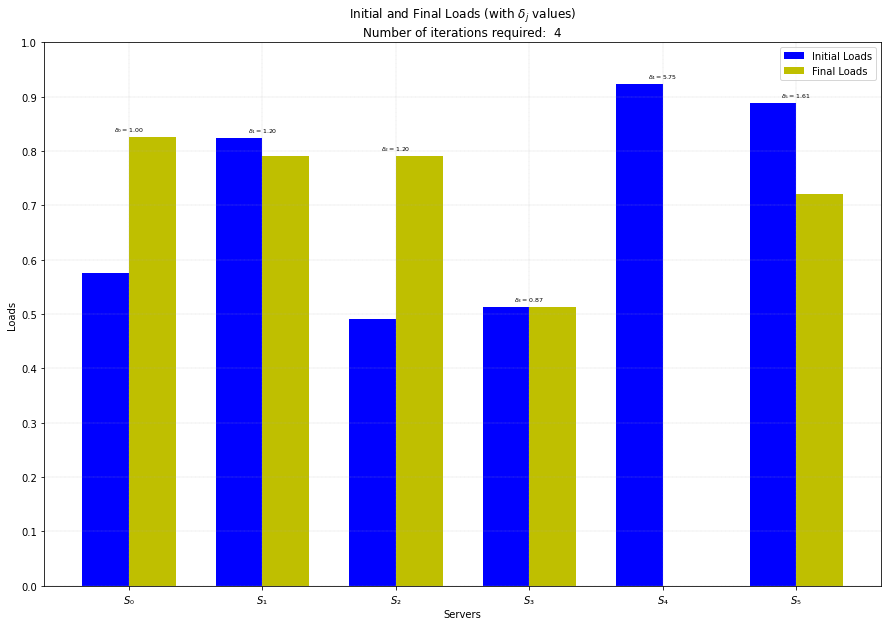

In [28]:
BarChart(M0,R)

In [29]:
def EvolutionLine(j,loads_dict,ls):
    ''' Returns a line-object depicting serverj's load evolution throughout iterations '''
    
    rd.seed(1)
    
    #palette  = plt.get_cmap(rd.choice(_PALETTES))
    #n_colors = len(palette.colors)
    #color    = palette(rd.choice(range(n_colors)))
    
    if len(loads_dict) == 1:
        x = np.array([0,1])
        y = np.array([loads_dict[0][j]*10]*2)
    else:
        x = np.arange(len(loads_dict)); x = x/x[-1]
        y = np.array([loads_dict[k][j]*10 for k in loads_dict])
    line = mlines.Line2D(x, y, lw=1., ls=ls, color='black')
    return line

In [30]:
R_DICT     = defaultdict(dict)
S0_DICT    = defaultdict(dict)
Splus_DICT = defaultdict(dict)
Sd_DICT    = defaultdict(dict)
for prob in _PROBS:
    p0 = prob[0]; p1 = prob[1]
    key = str((p0,p1))
    R,Sd,Splus,S0,it = LoadsEvolution(M0,p0=p0,p1=p1)
    R_DICT[key]     = R
    Sd_DICT[key]    = Sd
    S0_DICT[key]    = S0
    Splus_DICT[key] = Splus

In [31]:
S0_DICT, Splus_DICT, Sd_DICT 
# Check if all sets are equal!

(defaultdict(dict,
             {'(0.0, 0.0)': {4},
              '(0.1, 0.3)': {4},
              '(0.3, 0.1)': {4},
              '(0.3, 0.6)': {4}}),
 defaultdict(dict,
             {'(0.0, 0.0)': {1, 2, 5},
              '(0.1, 0.3)': {1, 2, 5},
              '(0.3, 0.1)': {1, 2, 5},
              '(0.3, 0.6)': {1, 2, 5}}),
 defaultdict(dict,
             {'(0.0, 0.0)': {3},
              '(0.1, 0.3)': {3},
              '(0.3, 0.1)': {3},
              '(0.3, 0.6)': {3}}))

In [32]:
for key in R_DICT:
    print('Probabilities: %s' % key)
    R = R_DICT[key]
    for it in R:
        print('Iter %i: %s' % (it,R[it]))
    print()

Probabilities: (0.0, 0.0)
Iter 0: [0.0, 0.824, 0.868, 0.513, 0.923, 0.889]
Iter 1: [1.0, 0, 0.868, 0.513, 0.923, 0.889]
Iter 2: [0.0, 0.824, 0.868, 0.513, 0.923, 0.889]
Iter 3: [0.253, 0.824, 0.868, 0.35, 0.923, 0.889]
Iter 4: [0.499, 0.399, 0.868, 0.564, 0.923, 0.889]
Iter 5: [0.529, 0.435, 0.868, 0.513, 0.923, 0.889]
Iter 6: [0.711, 0.653, 0.868, 0.513, 0, 0.889]
Iter 7: [0.799, 0.759, 0.868, 0.513, 0, 0.676]
Iter 8: [0.826, 0.791, 0.791, 0.513, 0, 0.72]

Probabilities: (0.1, 0.3)
Iter 0: [0.529, 0.435, 0.868, 0.513, 0.923, 0.889]
Iter 1: [0.677, 0.612, 0.612, 0.513, 0.923, 0.889]
Iter 2: [0.785, 0.742, 0.742, 0.513, 0, 0.889]
Iter 3: [0.826, 0.791, 0.791, 0.513, 0, 0.72]

Probabilities: (0.3, 0.1)
Iter 0: [1.0, 0.824, 0.868, 0, 0.923, 0]
Iter 1: [0.96, 0.824, 0.868, 0.513, 0.923, 0]
Iter 2: [0.0, 0.824, 0.868, 0.513, 0.923, 0.889]
Iter 3: [0.96, 0.824, 0.868, 0.513, 0.923, 0]
Iter 4: [0.0, 0.824, 0.868, 0.513, 0.923, 0.889]
Iter 5: [0.48, 0.824, 0.868, 0.513, 0, 0.889]
Iter 6: [0.74